In [1]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
from datasets import load_dataset, load_metric
import datasets
import torch
from bert_score import score

train_data = datasets.load_dataset("wmt16","de-en", split="train[:50000]")
val_data = datasets.load_dataset("wmt16","de-en", split="validation")
test_data = datasets.load_dataset("wmt16","de-en", split="test")

print(len(train_data))
print(len(val_data))
print(len(test_data))

/home/arnav/miniconda3/envs/DLA2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


50000
2169
2999


In [2]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small')

def preprocess_data(examples):
    inputs = ["translate German to English: " + ex["de"] for ex in examples["translation"]]
    targets = [ex["en"] for x in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_dataset = train_data.map(preprocess_data, batched=True)
validation_dataset = val_data.map(preprocess_data, batched=True)
test_dataset = test_data.map(preprocess_data, batched=True)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
from transformers import T5ForConditionalGeneration, Trainer, TrainingArguments

model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Ensure at least one layer is trainable
for name, param in model.named_parameters():
    if 'encoder' in name:
        param.requires_grad = True
        break

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

trainer.train()

/home/arnav/miniconda3/envs/DLA2/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,1.684700,0.476402
2,0.621900,0.460250
3,0.607400,0.452013
4,0.586000,0.447439
5,0.581800,0.444042
6,0.570300,0.441767
7,0.568500,0.440098
8,0.563400,0.438994
9,0.557500,0.438341
10,0.556400,0.438138


TrainOutput(global_step=7820, training_loss=0.6522681546028313, metrics={'train_runtime': 2601.0477, 'train_samples_per_second': 192.23, 'train_steps_per_second': 3.006, 'total_flos': 1.6917725184e+16, 'train_loss': 0.6522681546028313, 'epoch': 10.0})

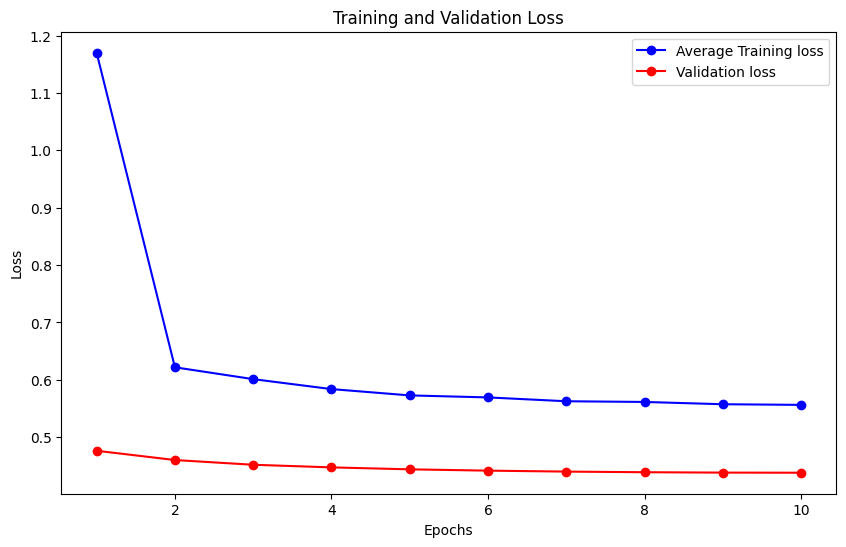

In [9]:
import matplotlib.pyplot as plt

# Initialize dictionaries to accumulate training losses and counts per epoch
training_losses_per_epoch = {}
training_loss_counts_per_epoch = {}

# Accumulate training losses and their counts per epoch
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        epoch = round(log['epoch'])  # Round to handle floating point epoch numbers
        if epoch not in training_losses_per_epoch:
            training_losses_per_epoch[epoch] = 0
            training_loss_counts_per_epoch[epoch] = 0
        training_losses_per_epoch[epoch] += log['loss']
        training_loss_counts_per_epoch[epoch] += 1

# Calculate average training loss per epoch
average_training_losses = [training_losses_per_epoch[epoch] / training_loss_counts_per_epoch[epoch] for epoch in sorted(training_losses_per_epoch)]

# Collect validation losses per epoch (assuming these are logged once per epoch)
validation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Ensure that the length of validation_losses matches the length of average_training_losses
# This is just a safety check; in practice, ensure that logging matches epochs
min_length = min(len(average_training_losses), len(validation_losses))
average_training_losses = average_training_losses[:min_length]
validation_losses = validation_losses[:min_length]
epochs = list(range(1, min_length + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, average_training_losses, 'bo-', label='Average Training loss')
plt.plot(epochs, validation_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [14]:
def evaluate_model(dataset):
    predictions, references = [], []
    for example in dataset:
        input_ids = tokenizer("translate German to English: " + example["translation"]["de"], return_tensors="pt").input_ids.to(model.device)
        output = model.generate(input_ids, max_new_tokens=128)
        pred_text = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(pred_text)
        references.append(example["translation"]["en"])

    # Load METEOR and BLEU metrics
    meteor_metric = load_metric('meteor', trust_remote_code=True)
    bleu_metric = load_metric('bleu', trust_remote_code=True)

    # Convert targets to the expected format for METEOR (list of lists, one reference per prediction)
    meteor_targets = [[target] for target in references]

    # Calculate METEOR score
    meteor_results = meteor_metric.compute(predictions=predictions, references=meteor_targets)

    # BLEU expects tokenized references and predictions, and references must be in a list of lists of lists
    bleu_targets_tokenized = [[[word for word in target.strip().split()] for target in [ref]] for ref in references]
    bleu_predictions_tokenized = [[word for word in pred.strip().split()] for pred in predictions]

    # Calculate BLEU score
    bleu_results = bleu_metric.compute(predictions=bleu_predictions_tokenized, references=bleu_targets_tokenized)

    # Calculate BERTScore
    from bert_score import score

    P, R, F1 = score(predictions, references, lang='en', verbose=True)

    return bleu_results['bleu'], meteor_results['meteor'], P, R, F1

bleu, meteor, bert_p, bert_r, bert_f1 = evaluate_model(validation_dataset)

print("VALIDATION DATA:")
print(f"BLEU: {bleu}")
print(f"METEOR: {meteor}")
print(f"BERTScore Precision: {bert_p.mean()}")
print(f"BERTScore Recall: {bert_r.mean()}")
print(f"BERTScore F1: {bert_f1.mean()}")

bleu, meteor, bert_p, bert_r, bert_f1 = evaluate_model(test_dataset)

print("TEST DATA:")
print(f"BLEU: {bleu}")
print(f"METEOR: {meteor}")
print(f"BERTScore Precision: {bert_p.mean()}")
print(f"BERTScore Recall: {bert_r.mean()}")
print(f"BERTScore F1: {bert_f1.mean()}")

[nltk_data] Downloading package wordnet to /home/arnav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/arnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/arnav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 68/68 [00:07<00:00,  8.54it/s]


computing greedy matching.


100%|██████████| 34/34 [00:00<00:00, 149.67it/s]


done in 8.20 seconds, 264.55 sentences/sec
VALIDATION DATA:
BLEU: 0.12460686818331085
METEOR: 0.35757361250587055
BERTScore Precision: 0.9027578830718994
BERTScore Recall: 0.908021092414856
BERTScore F1: 0.9052720069885254


[nltk_data] Downloading package wordnet to /home/arnav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/arnav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/arnav/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 94/94 [00:10<00:00,  8.64it/s]


computing greedy matching.


100%|██████████| 47/47 [00:00<00:00, 145.88it/s]

done in 11.21 seconds, 267.47 sentences/sec
TEST DATA:
BLEU: 0.1515262070024628
METEOR: 0.39126080342341524
BERTScore Precision: 0.9049018025398254
BERTScore Recall: 0.9115209579467773
BERTScore F1: 0.9080901145935059


In [16]:
# Save the model
model.save_pretrained("./t5-small-de-en-model")

# Save the tokenizer
tokenizer.save_pretrained("./t5-small-de-en-tokenizer")

('./t5-small-de-en-tokenizer/tokenizer_config.json',
 './t5-small-de-en-tokenizer/special_tokens_map.json',
 './t5-small-de-en-tokenizer/spiece.model',
 './t5-small-de-en-tokenizer/added_tokens.json')